In [1]:
!pip install -qq optuna-integration
!pip install -qq feature-engine

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [7]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from optuna_integration import XGBoostPruningCallback
from feature_engine.timeseries.forecasting import LagFeatures
from functools import partial
from sklearn.metrics import roc_auc_score
dset_path = '/kaggle/input/stocks-and-sentiments'
fpaths = [dset_path + f'/{fname}' for fname in os.listdir(dset_path)]
df = pd.read_csv(fpaths[0], index_col='date', parse_dates=['date']).drop(columns=['blob_sub_med', 'finbert_sent', 'blob_sub'])
df['clabel'] = df['return'].map(lambda x: 1 if x > 0 else 0)
print(fpaths[0].split('/')[-1][:-4])

AAPL


In [8]:
def tts_last_n(feature_sequences, target, n: int = 365) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    train_sequences = feature_sequences[:-n]
    test_sequences = feature_sequences[-n:]
    train_target = target[:-n]
    test_target = target[-n:]

    return train_sequences, test_sequences, train_target, test_target

def objective(trial, df):
    lags = trial.suggest_int('lags', 2, 20)
    og_cols = df.columns.tolist()
    og_cols.remove('clabel')
    lag_transformer = LagFeatures(periods=[x for x in range(1, lags + 1)])
    lagged_df = lag_transformer.fit_transform(df)
    lagged_df = lagged_df.dropna().drop(columns=og_cols)
    X = lagged_df.drop(columns=['clabel'])
    y = lagged_df.clabel
    X_train, X_test, y_train, y_test = tts_last_n(X, y, 252)
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
#         'device': 'cuda',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-10, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-10, 100.0, log=True),
        'random_state': 21052003
    }
    num_boost_round = trial.suggest_int('num_boost_rounds', 100, 1500)
    X_opt, X_val, y_opt, y_val = tts_last_n(X_train, y_train, 252)
    dopt = xgb.DMatrix(X_opt, y_opt)
    dval = xgb.DMatrix(X_val, y_val)
    
    pruning_callback = XGBoostPruningCallback(trial, 'validation-auc')
    bst = xgb.train(params=params,
                    dtrain=dopt,
                    evals=[(dval, 'validation')],
                    callbacks=[pruning_callback],
                    num_boost_round=num_boost_round,
                    verbose_eval=False)
    y_pred = bst.predict(dval)
    return roc_auc_score(y_val, y_pred)

objective_w = partial(objective, df=df)
study = optuna.create_study(direction='maximize')
study.optimize(objective_w, n_trials=1000)


with open('/kaggle/working/output.txt', 'w') as of:
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', file=of)
    trial = study.best_trial
    print('  Value: {:.5f}'.format(trial.value), file=of)
    print('  Params: ', file=of)
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value), file=of)

# model_name = input('Model name: ')

best_params = trial.params

const_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
#     'device': 'cuda',
    'random_state': 21052003
}

n_rounds = best_params['num_boost_rounds']
best_params.pop('num_boost_rounds')
best_params.update(const_params)



[I 2024-05-31 20:50:59,974] A new study created in memory with name: no-name-1f2adffd-4c2a-4d9b-99eb-c4c639020e63
[I 2024-05-31 20:51:00,828] Trial 0 finished with value: 0.5 and parameters: {'lags': 3, 'max_depth': 8, 'learning_rate': 0.041257651223674495, 'subsample': 0.8030454506957634, 'colsample_bytree': 0.9222608790811524, 'reg_alpha': 98.12765417499399, 'reg_lambda': 88.82809347407957, 'num_boost_rounds': 620}. Best is trial 0 with value: 0.5.
[I 2024-05-31 20:51:36,970] Trial 1 finished with value: 0.5224464060529634 and parameters: {'lags': 18, 'max_depth': 6, 'learning_rate': 0.00601488341385521, 'subsample': 0.7490540779095216, 'colsample_bytree': 0.9808296599477502, 'reg_alpha': 4.396204441958627e-09, 'reg_lambda': 2.286306099468803e-07, 'num_boost_rounds': 854}. Best is trial 1 with value: 0.5224464060529634.
[I 2024-05-31 20:51:44,487] Trial 2 finished with value: 0.5461538461538461 and parameters: {'lags': 4, 'max_depth': 5, 'learning_rate': 0.013798461445524306, 'subsam

Number of finished trials: 1000


In [10]:
lags = best_params['lags']
best_params.pop('lags')

og_cols = df.columns.tolist()
og_cols.remove('clabel')
lag_transformer = LagFeatures(periods=[x for x in range(1, lags + 1)])
lagged_df = lag_transformer.fit_transform(df)
lagged_df = lagged_df.dropna().drop(columns=og_cols)
X = lagged_df.drop(columns=['clabel'])
y = lagged_df.clabel
X_train, X_test, y_train, y_test = tts_last_n(X, y, 252)

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
model = xgb.train(best_params, dtrain, num_boost_round=n_rounds)
importance_dict = model.get_score(importance_type='weight')
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
preds = model.predict(dtest)
print(roc_auc_score(y_test, preds))
# Print the sorted key-value pairs
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

0.48865927419354843
rsi_ema_lag_1: 939.0
blob_pol_lag_1: 806.0
finbert_pos_lag_1: 471.0
vader_pos_lag_2: 451.0
return_lag_2: 434.0
volume_lag_2: 425.0
finbert_neg_lag_2: 424.0
vader_pos_lag_1: 420.0
finbert_neu_lag_2: 409.0
vader_neu_lag_2: 375.0
finbert_pos_lag_2: 374.0
blob_pol_lag_2: 352.0
finbert_neg_lag_1: 326.0
rsi_ema_lag_2: 323.0
return_lag_1: 276.0
volume_lag_1: 269.0
ewmstd_20_lag_1: 269.0
vader_neg_lag_1: 251.0
finbert_neu_lag_1: 232.0
vader_neu_lag_1: 231.0
ewmstd_20_lag_2: 227.0
vader_neg_lag_2: 208.0
macd_lag_1: 158.0
macd_lag_2: 130.0
ewma_20_lag_1: 86.0
ewma_60_lag_1: 81.0
open_lag_1: 62.0
ewma_60_lag_2: 58.0
ewma_20_lag_2: 52.0
adj_close_lag_1: 51.0
low_lag_1: 46.0
log1p_return_lag_2: 39.0
high_lag_1: 35.0
open_lag_2: 31.0
log1p_return_lag_1: 28.0
high_lag_2: 27.0
low_lag_2: 27.0
adj_close_lag_2: 12.0
clabel_lag_2: 1.0


In [11]:
for t, p in zip(y_test, preds):
    print(f'{t} {p}')

1 0.47065234184265137
0 0.5189043879508972
0 0.5076619386672974
0 0.48384585976600647
0 0.5388537645339966
0 0.5509284734725952
1 0.5151180028915405
1 0.5534857511520386
1 0.4054875373840332
1 0.4701915681362152
0 0.5148618221282959
0 0.4551321566104889
1 0.4997105002403259
0 0.4810556471347809
0 0.4865526854991913
1 0.5004813075065613
0 0.4908014237880707
1 0.4836479723453522
1 0.46918246150016785
1 0.500747561454773
1 0.5154166221618652
1 0.43352195620536804
0 0.46490201354026794
0 0.462611585855484
1 0.4923120141029358
0 0.5109392404556274
1 0.47008228302001953
1 0.4728529453277588
0 0.4631299674510956
0 0.529362678527832
0 0.5050005912780762
1 0.537726879119873
0 0.48994436860084534
1 0.5050482153892517
1 0.48590901494026184
1 0.4701353907585144
0 0.4754470884799957
0 0.4751470983028412
1 0.45190364122390747
0 0.4852973222732544
1 0.4466356337070465
0 0.4667574465274811
1 0.4997677803039551
0 0.4420485198497772
1 0.43025025725364685
1 0.49303945899009705
0 0.5147255659103394
1 0.45

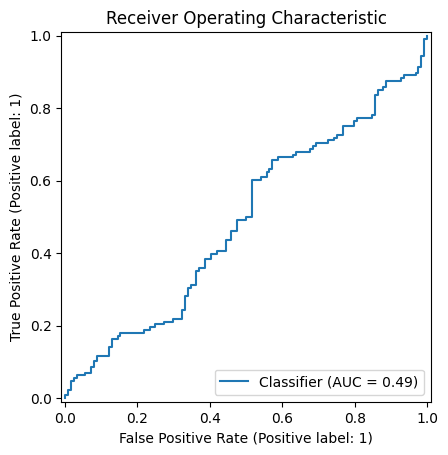

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Plot the ROC curve using RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, preds)
plt.title('Receiver Operating Characteristic')
plt.show()


In [13]:
X_train, X_test, y_train, y_test = tts_last_n(X, y, 252)
X_opt, X_val, y_opt, y_val = tts_last_n(X_train, y_train, 252)
dopt = xgb.DMatrix(X_opt, y_opt)
dval = xgb.DMatrix(X_val, y_val)

bst = xgb.train(params=best_params,
                dtrain=dopt,
                evals=[(dval, 'validation')],
                num_boost_round=n_rounds,
                verbose_eval=False)
y_pred = bst.predict(dval)
roc_auc_score(y_val, y_pred)

0.6034678436317781